First we import PyROOT.

In [1]:
import ROOT

Welcome to JupyROOT 6.26/06


Next, we generate a list of data filenames to be processed. Here glob is used for wildcarding. Output the number of files we have here.

In [2]:
import glob
import os
#filelist = glob.glob(os.path.expanduser("~/comet/phaseAlpha-decdata/rawdata0400?.root"))
filelist = glob.glob(os.path.expanduser("~/comet/phaseAlpha-decdata/rawdata02045.root"))
print("Number of files: ", len(filelist))

Number of files:  1


Set up a TChain, which is like a TTree but with data source from multiple files.

In [3]:
t = ROOT.TChain("tr")

Now we associate all the files in the filelist into this TChain.

In [4]:
for fn in filelist:
    t.Add(fn)

Here, we want to make sure the all the files are accounted for (nFiles == nTrees).

In [5]:
print("Number of trees: ", t.GetNtrees())

Number of trees:  1


Also, we would like to know how many events we have here.

In [6]:
print("Total number of events: ", t.GetEntries())

Total number of events:  277


Now we set up our analysis histograms.

In [7]:
hArea = [ROOT.TH1D("hArea_A", "Area of ch.A;Charge (pC)", 2000, -5, 1995),
         ROOT.TH1D("hArea_B", "Area of ch.B;Charge (pC)", 2000, -5, 1995),
         ROOT.TH1D("hArea_C", "Area of ch.C;Charge (pC)", 2000, -50, 1950),
         ROOT.TH1D("hArea_D", "Area of ch.D;Charge (pC)", 2000, -50, 1950)]

hAreaZoom = [ROOT.TH1D("hAreaZoom_A", "Area of ch.A;Charge (pC)", 250, -12.5, 50),
             ROOT.TH1D("hAreaZoom_B", "Area of ch.B;Charge (pC)", 250, -12.5, 50),
             ROOT.TH1D("hAreaZoom_C", "Area of ch.C;Charge (pC)", 250, -12.5, 50),
             ROOT.TH1D("hAreaZoom_D", "Area of ch.D;Charge (pC)", 250, -12.5, 50)]

hHeight = [ROOT.TH1D("hHeight_A", "Voltage of ch.A;Count", 500, -50, 950),
           ROOT.TH1D("hHeight_B", "Voltage of ch.B;Count", 500, -50, 950),
           ROOT.TH1D("hHeight_C", "Voltage of ch.C;Count", 500, -50, 950),
           ROOT.TH1D("hHeight_D", "Voltage of ch.D;Count", 500, -50, 950)]

hThretime = [ROOT.TH1D("hThretime_A", "T0R;Count", 10000, -10, 9990),
             ROOT.TH1D("hThretime_B", "T0L;Count", 10000, -10, 9990),
             ROOT.TH1D("hThretime_C", "T1;Count", 10000, -10, 9990),
             ROOT.TH1D("hThretime_D", "T2;Count", 10000, -10, 9990)]

hT1_T0 = ROOT.TH1D("T1_T0", "T1-T0;Time", 10000, -10, 9990)

hT1T2 = ROOT.TH1D("T1T2", "T1T2;Time", 10000, -10, 9990)

hT1T2_T0 = ROOT.TH1D("T1T2_T0", "T1T2-T0;Time", 10000, -10, 9990)

hT2_T1 = ROOT.TH1D("T2_T1", "T2-T1;Time", 10000, -5000, 5000)

hT1vsT2 = ROOT.TH2D("T1vsT2", "T2;T1", 10000, -10, 9990, 10000, -10, 9990)

Once we have the TChain and analysis histograms set up, it is now to process events from the datasets. We iterate over all events, and over all RC channels within an event.

The purpose of this analysis event loop is:
- Calculate baseline value
- Find minimum waveheight (or maximum amplitude actually)
- Set up vectors containing threshold crossing times for each channel
- Calculate waveform area

The above values will be filled into our analysis histograms.

In [8]:
# Define thresholds for different RC channels
thresholds = [-40, -40, -40, -20]

dt = 0.8

# Iterate over all events
for nev, entry in enumerate(t):
    # Now in an event
    
    # These lists will hold threshold crossing times for this event
    T0R = []
    T0L = []
    T1  = []
    T2  = []
    tT1T2 = []
    
    # Print event progress
    if nev <= 10 or (nev <= 100 and nev % 10 == 0) or (nev <= 1000 and nev % 100 == 0) or nev % 1000 == 0:
        print("Processing event ", nev, " ...")
    
    # Gather all 4 RC waveform references into a list
    wf = [t.pwfA, t.pwfB, t.pwfC, t.pwfD]
    
    # Iterate over all 4 RC channels
    for ch in range(4):
        # Inside a RC channel
        
        # Skip empty waveforms
        if wf[ch] == 0:
            continue
        
        # Get baseline
        base = 0.0
        baseSamples = 100
        for i in range(500, 500+baseSamples):
            base += wf[ch][i]
        base /= baseSamples
        
        # Find minimum waveheight
        minh = wf[ch][0]
        for h in wf[ch]:
            if h < minh:
                minh = h
        hHeight[ch].Fill(-minh)
        
        # Find threshold crossing times
        for i in range(len(wf[ch])-1):
            if (wf[ch][i] > thresholds[ch] and thresholds[ch] > wf[ch][i+1]):
                # Threshold crossing detected
                hThretime[ch].Fill(i+1)
                if ch == 0:
                    T0R.append(i+1)
                elif ch == 1:
                    T0L.append(i+1)
                elif ch == 2:
                    T1.append(i+1)
                else: # ch == 3
                    T2.append(i+1)
        
        # Measure area
        area = 0.0
        range0 = 0
        range1 = 1000
        for i in range(range0, range1):
            area += (wf[ch][i] - base)
        
        factor = 1e-3 * dt * 1e-9 / 50 / 1e-12
        hArea[ch].Fill(factor * area)
        hAreaZoom[ch].Fill(factor * area)
        
    # Done processing channels. Now processing the timings...
    # (Once we are done with our channel loop, it's time to process the threshold timings for this event
    # and fill up the rest of our analysis histograms.)
    
    # First, we histogram **ALL** the T1 and T0R differences.
    for t1 in T1:
        for t0r in T0R:
            a = t1 - t0r
            hT1_T0.Fill(a)
    
    # Next, we histogram T1 & T2 conincidences.
    # Here conincidence means that the timing difference is less than 13 time units.
    # We also record the T1 times of all conincidences into a vector.
    for t1 in T1:
        for t2 in T2:
            a = t2 - t1
            if 0 < a and a < 13:
                hT1T2.Fill(t1)
                tT1T2.append(t1)
                
    # Then, we histogram **ALL** time differences between the T1--T2 coincidences and T0R.
    for tt1t2 in tT1T2:
        for t0r in T0R:
            a = tt1t2 - t0r
            hT1T2_T0.Fill(a)
            
    # Then, we do the same for **ALL** time differences between T1 and T2.
    #
    # Last but not least, we build a 2-D T1 vs T2 histogram. This is in the same loop as previous.
    for t1 in T1:
        for t2 in T2:
            a = t2 - t1
            hT2_T1.Fill(a)
            hT1vsT2.Fill(t1, t2)

print("All events processed.")

Processing event  0  ...
Processing event  1  ...
Processing event  2  ...
Processing event  3  ...
Processing event  4  ...
Processing event  5  ...
Processing event  6  ...
Processing event  7  ...
Processing event  8  ...
Processing event  9  ...
Processing event  10  ...
Processing event  20  ...
Processing event  30  ...
Processing event  40  ...
Processing event  50  ...
Processing event  60  ...
Processing event  70  ...
Processing event  80  ...
Processing event  90  ...
Processing event  100  ...
Processing event  200  ...
All events processed.


Event loop done. Now we plot the histograms.

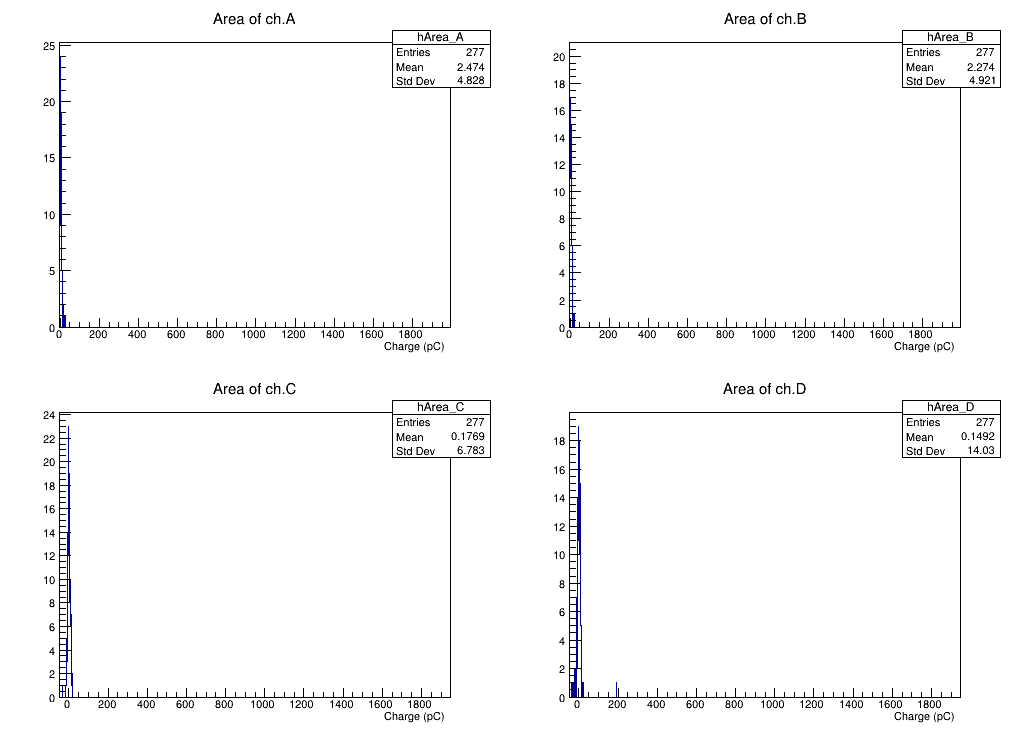

In [9]:
c1 = ROOT.TCanvas("c1", "histograms", 1024, 768)
c1.Divide(2,2)
for i in range(4):
    c1.cd(i+1)
    hArea[i].Draw()
c1.Update()
c1.Draw()

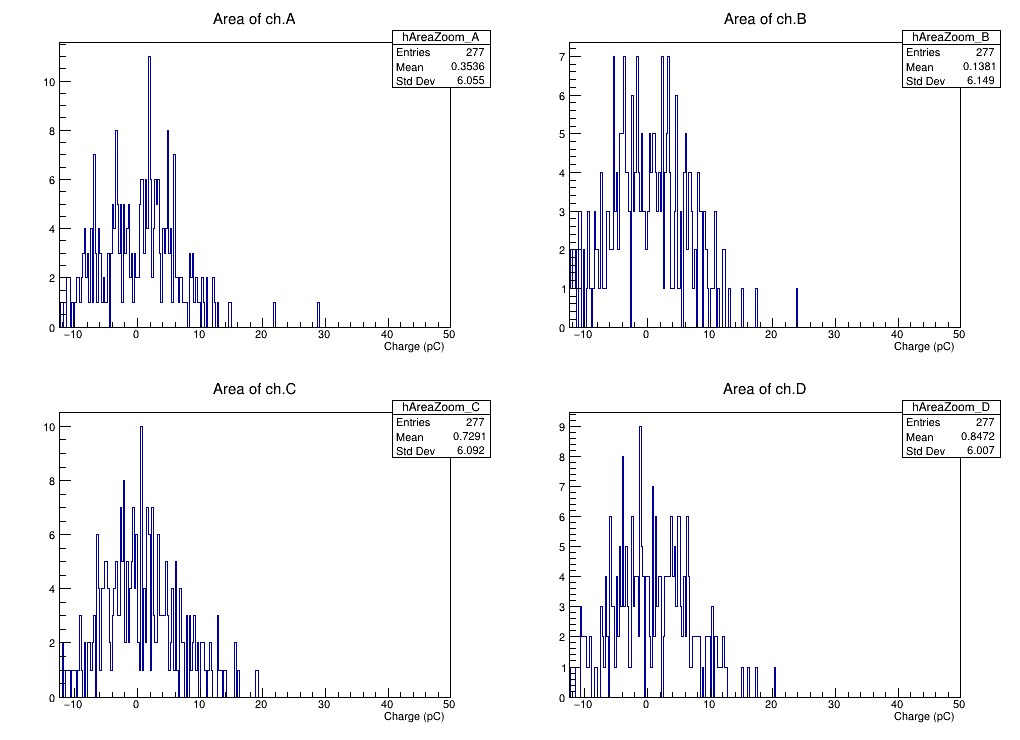

In [10]:
for i in range(4):
    c1.cd(i+1)
    hAreaZoom[i].Draw()
c1.Update()
c1.Draw()

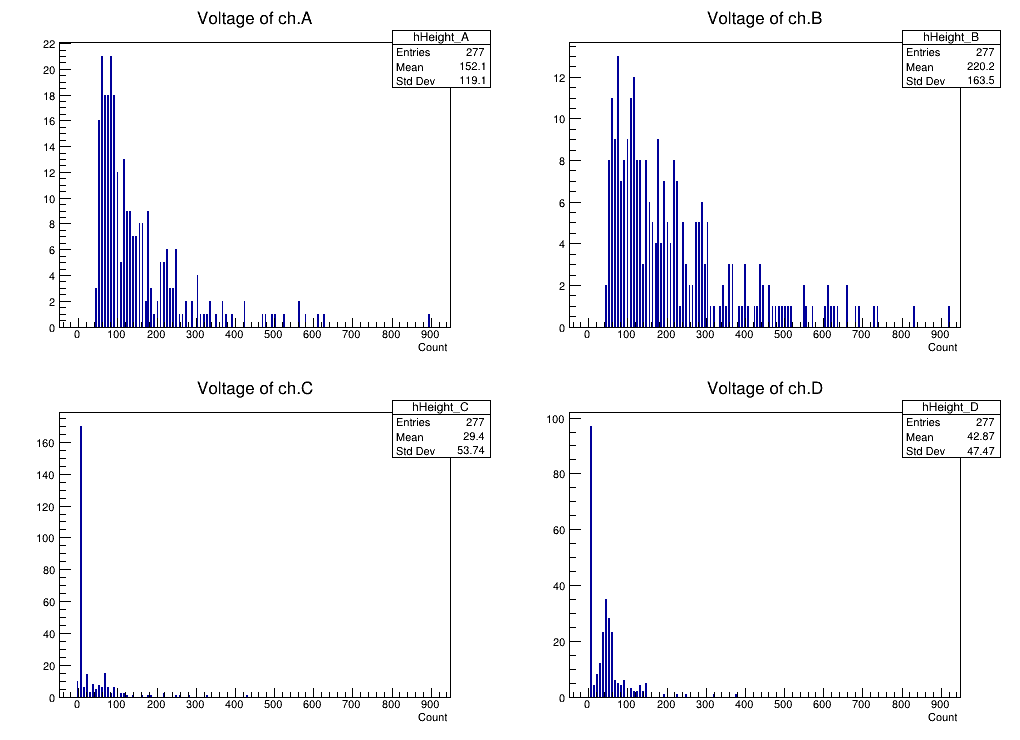

In [11]:
for i in range(4):
    c1.cd(i+1)
    hHeight[i].Draw()
c1.Update()
c1.Draw()

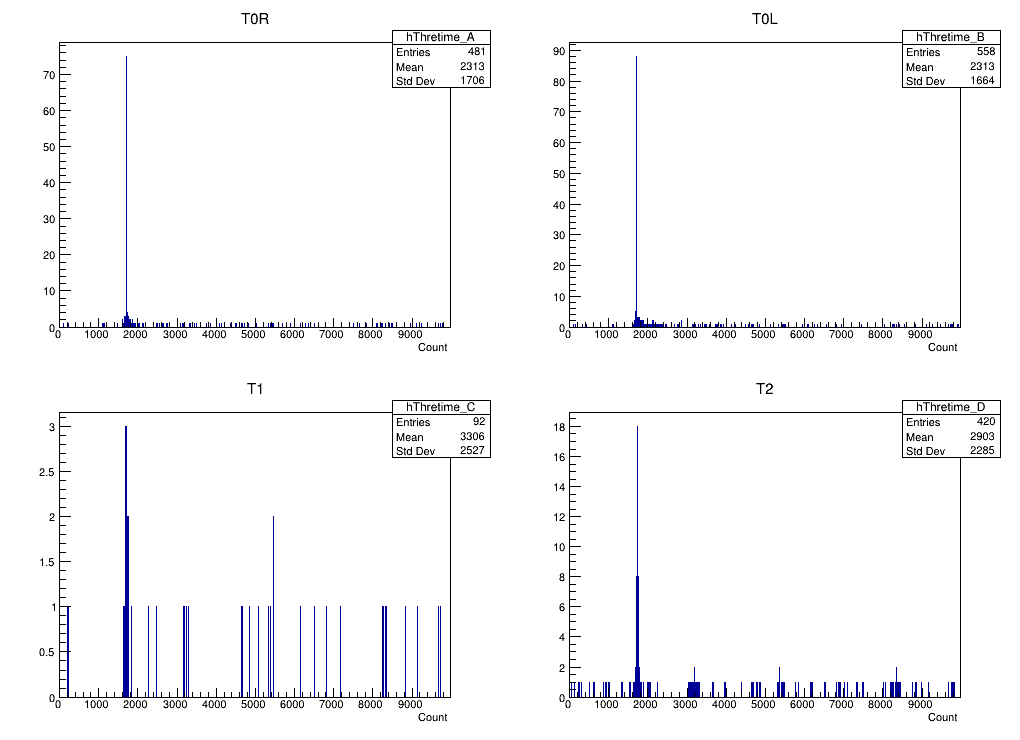

In [12]:
for i in range(4):
    c1.cd(i+1)
    hThretime[i].Draw()
c1.Update()
c1.Draw()

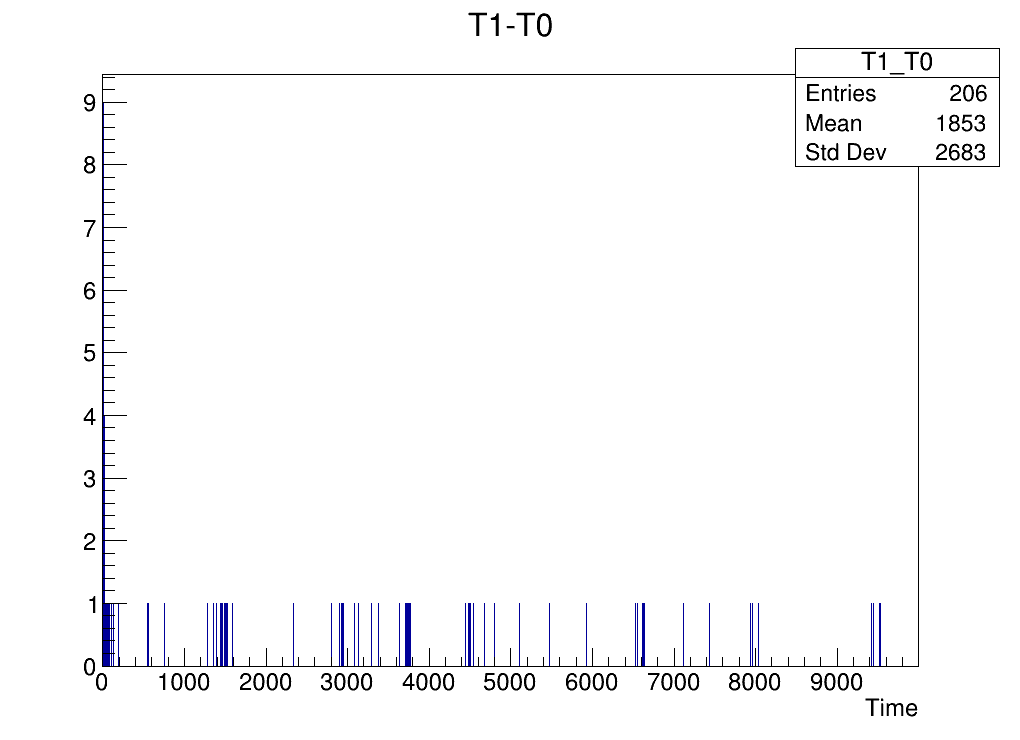

In [13]:
c2 = ROOT.TCanvas("c2", "Timing histograms", 1024, 768)
hT1_T0.Draw()
c2.Update()
c2.Draw()

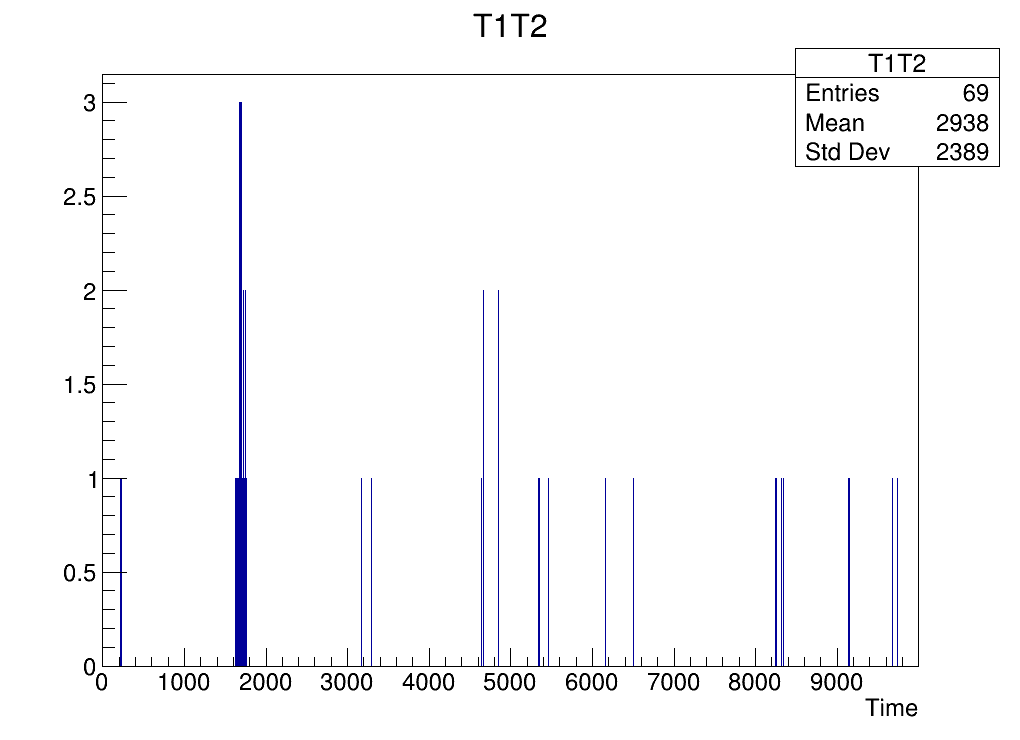

In [14]:
hT1T2.Draw()
c2.Update()
c2.Draw()

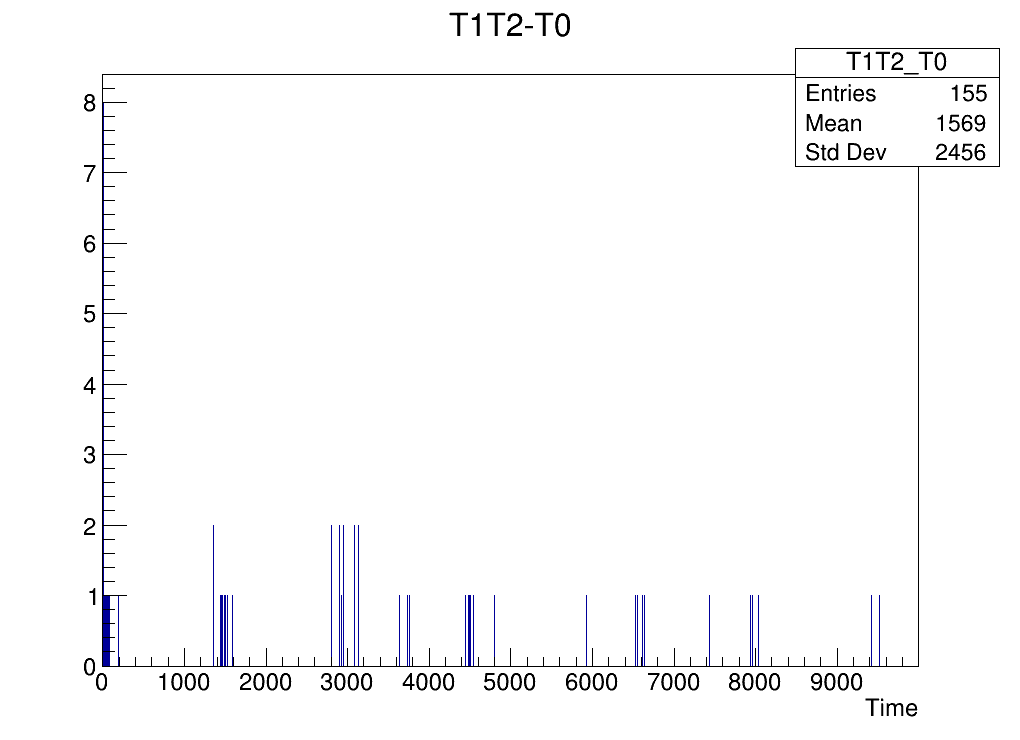

In [15]:
hT1T2_T0.Draw()
c2.Update()
c2.Draw()

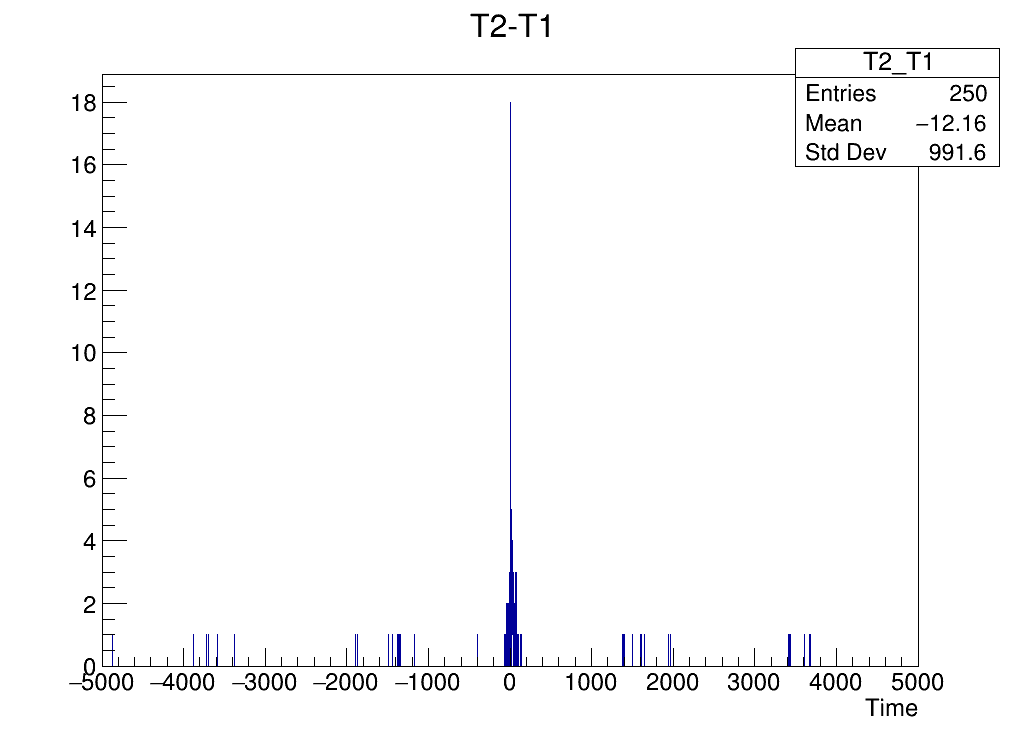

In [16]:
hT2_T1.Draw()
c2.Update()
c2.Draw()

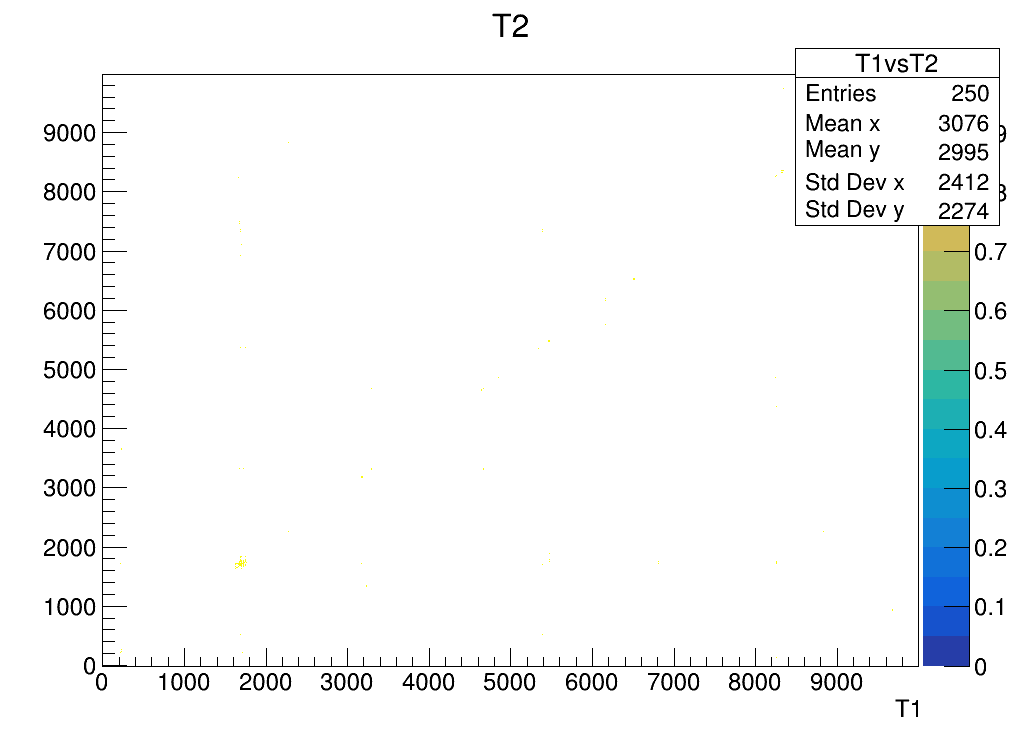

In [17]:
hT1vsT2.Draw("COLZ")
c2.Update()
c2.Draw()